# Real estate rental hedonic model workflow

Paul Waddell, July 2018

Python 3.6, intended to be backward compatible with 2.7

In [1]:
from __future__ import print_function
import warnings;warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import norm
%matplotlib inline

import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import seaborn as sns
sns.set()

In [3]:
# Standard to run UrbanSim from the root level of the project directory

import os; os.chdir('../..')

In [4]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import OLSRegressionStep
import orca

In [5]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

## Explore the Orca registrations

In [6]:
orca.list_tables()

['parcels',
 'buildings',
 'craigslist',
 'rentals',
 'units',
 'households',
 'persons',
 'jobs']

In [ ]:
for table_name in orca.list_tables():
    print(table_name.upper())
    print(orca.get_table(table_name).to_frame().columns.tolist())
    print()

In [ ]:
orca.list_broadcasts()

In [ ]:
orca.list_steps()

## Explore the data

Orca doesn't execute code to load the registered objects until it needs to.

In [ ]:
orca.get_table('parcels').to_frame().describe()

In [131]:
buildings = orca.get_table('buildings').to_frame()
buildings.columns

Index(['parcel_id', 'development_type_id', 'improvement_value',
       'residential_units', 'residential_sqft', 'sqft_per_unit',
       'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft',
       'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price',
       'redfin_sale_year', 'redfin_home_type', 'costar_property_type',
       'costar_rent', 'building_type_id', 'res_sqft_per_unit', 'node_id_small',
       'node_id_walk'],
      dtype='object')

In [132]:
buildings.sqft_per_unit.describe()

count    1.824229e+06
mean     1.669294e+03
std      1.063476e+03
min      0.000000e+00
25%      1.176000e+03
50%      1.564000e+03
75%      2.029424e+03
max      3.000000e+04
Name: sqft_per_unit, dtype: float64

In [ ]:
buildings.building_type_id.value_counts()

In [ ]:
buildings.residential_units.value_counts()

In [104]:
households = orca.get_table('households').to_frame()
households.columns

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk'],
      dtype='object')

In [105]:
households.describe()

,serialno,persons,building_type,cars,income,race_of_head,age_of_head,workers,state,county,tract,block_group,children,tenure,recent_mover,block_group_id,unit_id,building_id,node_id_small,node_id_walk
count,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2677468.0,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.485869e+06,2.485869e+06
mean,2.011048e+12,2.637121e+00,3.586621e+00,1.882801e+00,1.131284e+05,2.837879e+00,5.296986e+01,1.302752e+00,6.0,5.435264e+01,3.526555e+05,2.118013e+00,5.626338e-01,1.426969e+00,3.883258e-02,6.054705e+10,1.288427e+06,8.580958e+05,7.846705e+08,1.433347e+09
std,1.416906e+09,1.573306e+00,2.335401e+00,1.139782e+00,1.079526e+05,2.662159e+00,1.568676e+01,9.979341e-01,0.0,3.761145e+01,1.832935e+05,1.119816e+00,9.710445e-01,4.946378e-01,1.931958e-01,3.759562e+08,8.497798e+05,5.611658e+05,1.387397e+09,2.045733e+09
min,2.009000e+12,1.000000e+00,1.000000e+00,0.000000e+00,-1.160000e+04,1.000000e+00,1.500000e+01,0.000000e+00,6.0,1.000000e+00,1.010000e+04,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,6.001400e+10,-1.000000e+00,-1.000000e+00,2.812660e+05,2.602875e+07
25%,2.010000e+12,1.000000e+00,2.000000e+00,1.000000e+00,4.032000e+04,1.000000e+00,4.100000e+01,1.000000e+00,6.0,1.300000e+01,2.007070e+05,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,6.013322e+10,5.409708e+05,3.599548e+05,5.793535e+07,5.789404e+07
50%,2.011001e+12,2.000000e+00,2.000000e+00,2.000000e+00,8.400000e+04,1.000000e+00,5.300000e+01,1.000000e+00,6.0,7.500000e+01,4.070000e+05,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,6.075026e+10,1.272990e+06,8.378585e+05,6.550172e+07,6.549642e+07
75%,2.012001e+12,4.000000e+00,5.000000e+00,2.000000e+00,1.501000e+05,6.000000e+00,6.300000e+01,2.000000e+00,6.0,8.500000e+01,5.044140e+05,3.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,6.085506e+10,2.024749e+06,1.341263e+06,6.125957e+08,3.049074e+09
max,2.013001e+12,2.000000e+01,1.000000e+01,6.000000e+00,1.397000e+06,9.000000e+00,9.400000e+01,1.300000e+01,6.0,9.700000e+01,9.832000e+05,7.000000e+00,9.000000e+00,2.000000e+00,1.000000e+00,6.097154e+10,2.781489e+06,1.843272e+06,5.458527e+09,5.466634e+09


In [ ]:
households.race_of_head.value_counts()

In [ ]:
households.hispanic_head.value_counts()

In [ ]:
rentals = orca.get_table('craigslist').to_frame()
rentals.columns

In [ ]:
rentals.describe()

In [ ]:
rents_nodup = rentals.drop_duplicates(['pid'])
rents_nodup.describe()

In [ ]:
rents_nodup.rent.quantile([0.005, 0.995])

In [ ]:
rents_nodup.bedrooms.quantile([0.005, 0.995])

In [ ]:
rents_nodup.sqft.quantile([0.005, 0.995])

In [ ]:
rentlow = rents_nodup.rent.quantile(0.005)
renthigh = rents_nodup.rent.quantile(0.995)
bedshigh = rents_nodup.bedrooms.quantile(0.995)
sqftlow = rents_nodup.sqft.quantile(0.005)
sqfthigh = rents_nodup.sqft.quantile(0.995)

In [ ]:
rent_mask = (rents_nodup['rent'] > rentlow) & (rents_nodup['rent'] <= renthigh)
beds_mask = (rents_nodup['bedrooms'] <= bedshigh)
sqft_mask = (rents_nodup['sqft'] > sqftlow) & (rents_nodup['sqft'] <= sqfthigh)

# filter the thorough listings according to these masks
filtered_rents = pd.DataFrame(rents_nodup[rent_mask & beds_mask & sqft_mask])
len(filtered_rents)

In [ ]:
plt.rcParams['figure.figsize']=10,10
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(filtered_rents.rent, bins=50, fit=norm,  kde=False)

In [ ]:
plt.rcParams['figure.figsize']=10,10
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(np.log(filtered_rents.rent), bins=50, fit=norm, kde=False)

In [ ]:
filtered_rents.describe()

In [ ]:
filtered_rents.to_csv('data/rental_listings_cleaned.csv')

## Generate accessibility measures for the price model

The network accessibility metrics are not stored on disk; for now we'll generate them using legacy code.

In [7]:
orca.run(['initialize_network_small'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 30.09 s
Total time to execute iteration 1 with iteration value None: 30.09 s


In [8]:
orca.run(['network_aggregations_small'])

Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 191599 rows because they contain missing values
Computing hh_10000
Removed 191599 rows because they contain missing values
Computing poor_10000
Removed 53660 rows because they contain missing values
Computing renters_10000
Removed 103635 rows because they contain missing values
Computing med_income_10000
Removed 191599 rows because they contain missing values
Computing jobs_10000
Computing med_rent_10000
Computing pop_white_10000
Removed 108381 rows because they contain missing values
Computing pop_black_10000
Removed 10605 rows because they contain missing values
Computing pop_asian_10000
Removed 51665 rows because they contain missing values
Computing pop_hisp_10000
Removed 31878 rows because they contain missing values
Computing units_25000
Computing units_sf_25000
Computing units_mf_25000
Computing pop_25000


In [ ]:
#orca.run(['initialize_network_drive'])

In [ ]:
#orca.run(['network_aggregations_drive'])

In [10]:
orca.run(['initialize_network_walk'])

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 52.78 s
Total time to execute iteration 1 with iteration value None: 52.78 s


In [16]:
orca.run(['network_aggregations_walk'])

Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk
Computing sqft_unit_500_walk
Computing singles_500_walk
Removed 52731 rows because they contain missing values
Computing elderly_hh_500_walk
Removed 34788 rows because they contain missing values
Computing children_500_walk
Removed 191599 rows because they contain missing values
Computing units_sf_500_walk
Computing units_mf_500_walk
Computing pop_500_walk
Removed 191599 rows because they contain missing values
Computing hh_500_walk
Removed 191599 rows because they contain missing values
Computing poor_500_walk
Removed 53660 rows because they contain missing values
Computing rich_500_walk
Removed 39177 rows because they contain missing values
Computing renters_500_walk
Removed 103635 rows because they contain missing values
Computing med_income_500_walk
Removed 191599 rows because they contain missing values
Computing jobs_500_walk
Computing med_rent_500_walk
Computing pop_white_500_walk

In [ ]:
orca.list_tables()

In [ ]:
#print(orca.get_table('nodesdrive').to_frame().columns.tolist())

In [ ]:
#nodesdrive = orca.get_table('nodesdrive').to_frame()

In [ ]:
#nodesdrive.to_csv('data/nodesdrive.csv')

In [18]:
nodessmall = orca.get_table('nodessmall').to_frame()

In [20]:
nodessmall.to_csv('data/nodessmall_vars.csv')

In [21]:
nodeswalk = orca.get_table('nodeswalk').to_frame()

In [22]:
nodeswalk.to_csv('data/nodeswalk_vars.csv')

In [ ]:
rentals = orca.get_table('rentals').to_frame()

In [ ]:
rentals.head()

In [ ]:
rentals.node_id_drive.isnull().sum()

In [ ]:
print('{} nodes have median income zero or below'.format(len(nodessmall[nodessmall.med_income_10000 == -1])))

print('Total nodes count {}'.format(len (nodessmall)))

# Estimate a rental hedonic model

The basic idea of the parcel template is that we create model steps by _passing arguments to classes_ rather than by writing Python functions and giving them Orca decorators, as we would for a fully custom model.

Much of the functionality for this is already built into UrbanSim and Orca, we'll just need to extend things here and there.

This demo uses a new RegressionStep() class that provides a full model development workflow: estimating a model, registering it with Orca, saving it for future use.

### Specify parameters and pass them to a model object

In [33]:
m = OLSRegressionStep()
m.tables = ['rentals', 'nodessmall', 'nodeswalk']
m.filters = ['rent_sqft < 10' ]
m.model_expression = 'np.log1p(rent_sqft) ~ +  np.log(units_500_walk+1) + np.log(sqft_unit_500_walk+2)  + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_1500_walk+1) + np.log(jobs_10000+1) + np.log(jobs_25000 + 1) + \
    np.log(pop_10000+1) + np.log(pop_black_10000+1) + np.log(pop_hisp_10000+1) + \
    np.log(pop_asian_10000+1)  '
m.name = 'hedonic_rent_sqft'
m.tags = ['paul', 'version 1']

m.fit()

                             OLS Regression Results                            
Dep. Variable:     np.log1p(rent_sqft)   R-squared:                       0.370
Model:                             OLS   Adj. R-squared:                  0.370
Method:                  Least Squares   F-statistic:                 1.524e+04
Date:                 Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                         12:17:11   Log-Likelihood:                 73077.
No. Observations:               362901   AIC:                        -1.461e+05
Df Residuals:                   362886   BIC:                        -1.460e+05
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [36]:
orca.list_tables()

['parcels',
 'buildings',
 'craigslist',
 'rentals',
 'units',
 'households',
 'persons',
 'jobs',
 'nodessmall',
 'nodeswalk']

In [24]:
rentals = orca.get_table('rentals').to_frame()
rentals['predicted_ln_rent_sqft'] = 0.0
orca.add_table('rentals', rentals)
m.out_column = 'predicted_ln_rent_sqft'
m.run()

In [25]:
rentals['predicted_rent_sqft'] = np.exp(rentals['predicted_ln_rent_sqft']) - 1

In [26]:
rentals['residuals_rent_sqft'] = rentals.predicted_rent_sqft - rentals.rent_sqft

In [27]:
rentals.head()

,Unnamed: 0,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,longitude,latitude,county,fips_block,state,bathrooms,node_id_small,node_id_walk,predicted_ln_rent_sqft,predicted_rent_sqft,residuals_rent_sqft
pid,,,,,,,,,,,,,,,,,,,
5873885791,0,11/13/2016 0:00,sacramento,,1717,2,943,1.820785,-121.962386,38.357364,Solano,6.095250e+13,CA,,62413119,57938834,1.158201,2.184200,0.363415
5873796738,1,11/13/2016 0:00,sacramento,Fairfield,1275,2,900,1.416667,-122.019980,38.262374,Solano,6.095250e+13,CA,,62388472,57793805,1.048914,1.854549,0.437883
5873897352,2,11/13/2016 0:00,sfbay,dublin / pleasanton / livermore,2250,1,687,3.275109,-121.888125,37.708458,Alameda,6.001450e+13,CA,,3110365111,3110365111,1.349622,2.855968,-0.419141
5873905471,3,11/13/2016 0:00,sfbay,potrero hill,5180,2,1060,4.886792,-122.403979,37.769428,San Francisco,6.075060e+13,CA,,2304626340,3985226614,1.690362,4.421441,-0.465351
5873905300,4,11/13/2016 0:00,sfbay,santa clara,2588,2,1070,2.418692,-121.959929,37.397865,Santa Clara,6.085500e+13,CA,,1071836625,4106391993,1.440904,3.224511,0.805819


In [28]:
rentals[['rent_sqft','predicted_rent_sqft','residuals_rent_sqft']].describe()

,rent_sqft,predicted_rent_sqft,residuals_rent_sqft
count,363055.000000,363055.000000,363055.000000
mean,3.177249,3.091458,-0.085790
std,1.089517,0.604379,0.867157
min,0.283500,0.259384,-16.763313
25%,2.493750,2.682596,-0.488420
50%,2.998120,3.105174,0.011978
75%,3.675385,3.486493,0.437125
max,19.609375,5.113818,4.379918


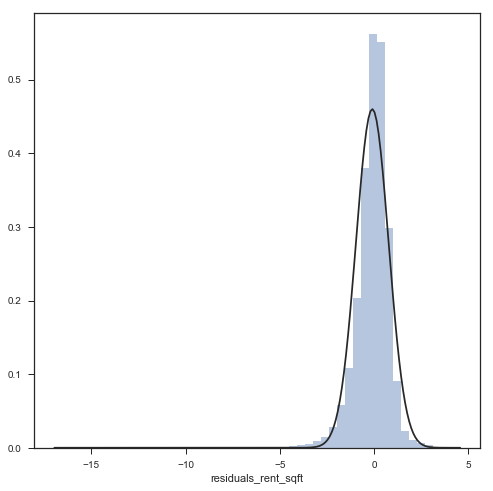

In [29]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(rentals.residuals_rent_sqft, fit=norm, kde=False)

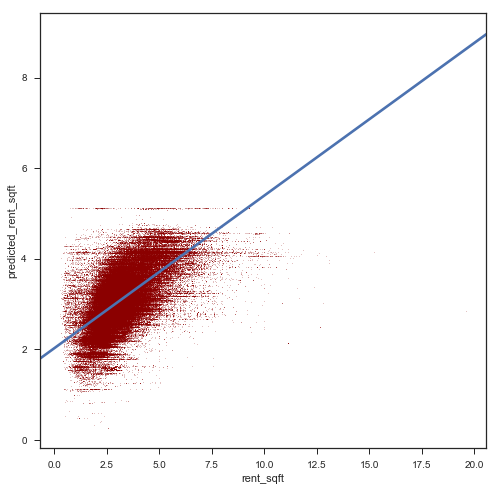

In [30]:
ax = sns.regplot(y = rentals.predicted_rent_sqft, x = rentals.rent_sqft, \
                 scatter_kws={"color":"darkred","alpha":0.3,"s":1}\
               )

In [34]:
m.register()

In [35]:
orca.list_steps()

['large-mnl-test',
 'model_one',
 'model_two',
 'ols-test',
 'small-mnl-test',
 'test_manual_registration',
 'initialize_network_small',
 'initialize_network_drive',
 'initialize_network_walk',
 'network_aggregations_drive',
 'network_aggregations_small',
 'network_aggregations_walk',
 'OLSRegressionStep-20180716-121000',
 'hedonic_rent_sqft']

In [98]:
m_rent = OLSRegressionStep()
m_rent.tables = ['rentals', 'nodessmall', 'nodeswalk']
m_rent.model_expression = 'np.log1p(rent) ~ + np.log(sqft) + C(bedrooms) + np.log(units_500_walk + 1) +\
    np.log(jobs_500_walk + 1) + np.log(jobs_1500_walk+1) + np.log(jobs_10000+1) + np.log(jobs_25000) + \
    np.log(pop_10000+1) + np.log(pop_black_10000+1) + np.log(pop_hisp_10000+1) + \
    np.log(pop_asian_10000+1)'
m_rent.fit()

                            OLS Regression Results                            
Dep. Variable:         np.log1p(rent)   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 3.641e+04
Date:                Sun, 15 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:54:34   Log-Likelihood:                 41128.
No. Observations:              363055   AIC:                        -8.222e+04
Df Residuals:                  363039   BIC:                        -8.205e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [99]:
rentals['predicted_ln_rent'] = 0.0
m_rent.out_column = 'predicted_ln_rent'
m_rent.run()
rentals = orca.get_table('rentals').to_frame()
rentals['predicted_rent'] = np.exp(rentals.predicted_ln_rent)
rentals['residuals_rent'] = rentals.predicted_rent - rentals.rent

In [100]:
rentals.head()

,Unnamed: 0,date,region,neighborhood,rent,bedrooms,sqft,rent_sqft,longitude,latitude,...,state,bathrooms,node_id_small,node_id_walk,predicted_rent_sqft,residuals_rent_sqft,predicted_ln_rent_sqft,predicted_ln_rent,predicted_rent,residuals_rent
pid,,,,,,,,,,,,,,,,,,,,,
5873885791,0,11/13/2016 0:00,sacramento,,1717,2,943,1.820785,-121.962386,38.357364,...,CA,,62413119,62413119,3.299259,1.478474,1.193698,7.657601,2116.673233,399.673233
5873796738,1,11/13/2016 0:00,sacramento,Fairfield,1275,2,900,1.416667,-122.019980,38.262374,...,CA,,62388472,62424431,2.623970,1.207303,0.964688,7.353227,1561.226418,286.226418
5873897352,2,11/13/2016 0:00,sfbay,dublin / pleasanton / livermore,2250,1,687,3.275109,-121.888125,37.708458,...,CA,,3110365111,3110365111,4.160083,0.884974,1.425535,7.771571,2372.194640,122.194640
5873905471,3,11/13/2016 0:00,sfbay,potrero hill,5180,2,1060,4.886792,-122.403979,37.769428,...,CA,,2304626340,3985226614,4.904011,0.017219,1.590054,8.218186,3707.769417,-1472.230583
5873905300,4,11/13/2016 0:00,sfbay,santa clara,2588,2,1070,2.418692,-121.959929,37.397865,...,CA,,1071836625,4106391993,4.253634,1.834943,1.447774,8.074508,3211.547168,623.547168


In [101]:
rentals[['rent','predicted_rent', 'residuals_rent']].describe()

,rent,predicted_rent,residuals_rent
count,363055.000000,363055.000000,363055.000000
mean,2928.400578,2854.744078,-73.656500
std,1103.376658,769.067056,694.511661
min,905.000000,465.581220,-6642.274957
25%,2200.000000,2328.159406,-342.543711
50%,2695.000000,2754.677173,18.913014
75%,3400.000000,3281.467553,296.238999
max,9800.000000,9287.569689,7961.569689


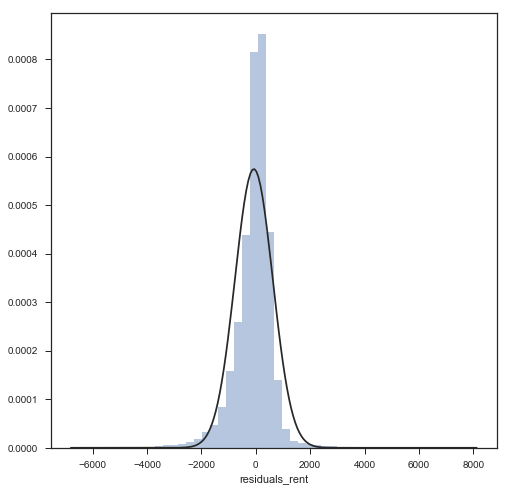

In [102]:
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(rentals.residuals_rent, fit=norm, kde=False)

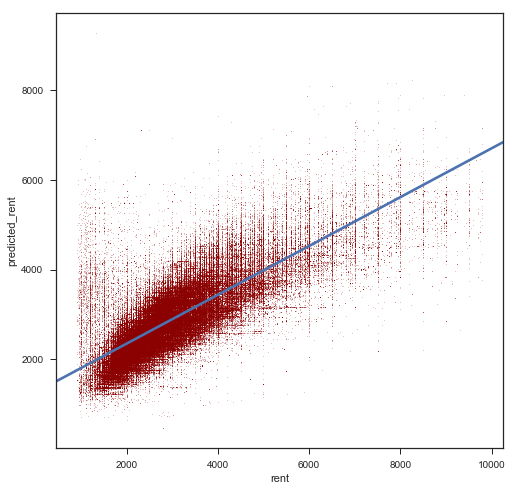

In [103]:
ax = sns.regplot(y = rentals.predicted_rent, x = rentals.rent, \
                 scatter_kws={"color":"darkred","alpha":0.3,"s":1}\
               )

### If we like it, register it as an Orca step

In [ ]:
model.register()

In [ ]:
orca.list_steps()

### Run the Orca step

In [ ]:
orca.run(['RegressionStep-20180214-210159'])

### Check the fitted values

In [ ]:
df = orca.get_table('buildings').to_frame(['res_price_per_sqft', 'fitted_price'])
df.loc[df.fitted_price > 0].describe()

### BONUS

Running "model.register()" also registered the step with the new ModelManager extention, which saves it to disk so that it can be automatically re-loaded in the future.

The "test" model steps here were estimated earlier and loaded from disk. They're fully functional: we can run them in Orca, inspect the estimation results, etc.

In [ ]:
mm.list_steps()

In [ ]:
rs = mm.get_step('test-1')
type(rs)

In [ ]:
rs.model_expression

In [ ]:
rs.model.report_fit()